<a href="https://colab.research.google.com/github/jessicabrooke10/Senior-Design-Project/blob/Mason-Model/prophet_model_setup_booleanschedule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
# Load the CSV file and adjust column names
file_path = 'aggregated2.csv'
data = pd.read_csv(file_path, header=None, names=['ds', 'y'])

# Convert the 'ds' column to datetime format
data['ds'] = pd.to_datetime(data['ds'])

In [3]:
# Initialize the Prophet model
model = Prophet()

# Fit the model with the data
model.fit(data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvxg1snzw/utv6znfm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvxg1snzw/a693w9dl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12340', 'data', 'file=/tmp/tmpvxg1snzw/utv6znfm.json', 'init=/tmp/tmpvxg1snzw/a693w9dl.json', 'output', 'file=/tmp/tmpvxg1snzw/prophet_model759ab81r/prophet_model-20240414185248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [4]:
# Create a future dataframe for the next 24 hours at 5-minute intervals -- 288 periods = (24hrs * 60 min/hr) / (5 mininterval)
future = model.make_future_dataframe(periods=288, freq='5min')

# Make Prediction
forecast = model.predict(future)

In [5]:
# Filter forecast for future predictions only
last_history_time = data['ds'].max()
future_forecast = forecast[forecast['ds'] > last_history_time]

# Calculate the median of the future CPU usage
median_cpu_usage = future_forecast['yhat'].median()

# Create a new DataFrame for the next 24 hours at 30-minute intervals
time_range = pd.date_range(start=last_history_time, periods=48, freq='30min')
server_on_off_df = pd.DataFrame(time_range, columns=['Time'])
server_on_off_df['Servers'] = False  # Initialize column with False

# For each time in the new DataFrame, determine if we're turning servers on or off based on the median
for index, row in server_on_off_df.iterrows():
    # Find the closest time in the future_forecast and its predicted value
    closest_time = future_forecast.iloc[(future_forecast['ds'] - row['Time']).abs().argsort()[:1]]
    if closest_time['yhat'].values[0] > median_cpu_usage:
        server_on_off_df.at[index, 'Servers'] = True

# Display the new DataFrame
print(server_on_off_df)

                  Time  Servers
0  2023-10-17 19:30:00     True
1  2023-10-17 20:00:00     True
2  2023-10-17 20:30:00     True
3  2023-10-17 21:00:00     True
4  2023-10-17 21:30:00     True
5  2023-10-17 22:00:00     True
6  2023-10-17 22:30:00     True
7  2023-10-17 23:00:00    False
8  2023-10-17 23:30:00    False
9  2023-10-18 00:00:00    False
10 2023-10-18 00:30:00    False
11 2023-10-18 01:00:00    False
12 2023-10-18 01:30:00    False
13 2023-10-18 02:00:00    False
14 2023-10-18 02:30:00    False
15 2023-10-18 03:00:00    False
16 2023-10-18 03:30:00    False
17 2023-10-18 04:00:00    False
18 2023-10-18 04:30:00    False
19 2023-10-18 05:00:00    False
20 2023-10-18 05:30:00    False
21 2023-10-18 06:00:00    False
22 2023-10-18 06:30:00    False
23 2023-10-18 07:00:00    False
24 2023-10-18 07:30:00     True
25 2023-10-18 08:00:00     True
26 2023-10-18 08:30:00     True
27 2023-10-18 09:00:00     True
28 2023-10-18 09:30:00     True
29 2023-10-18 10:00:00     True
30 2023-

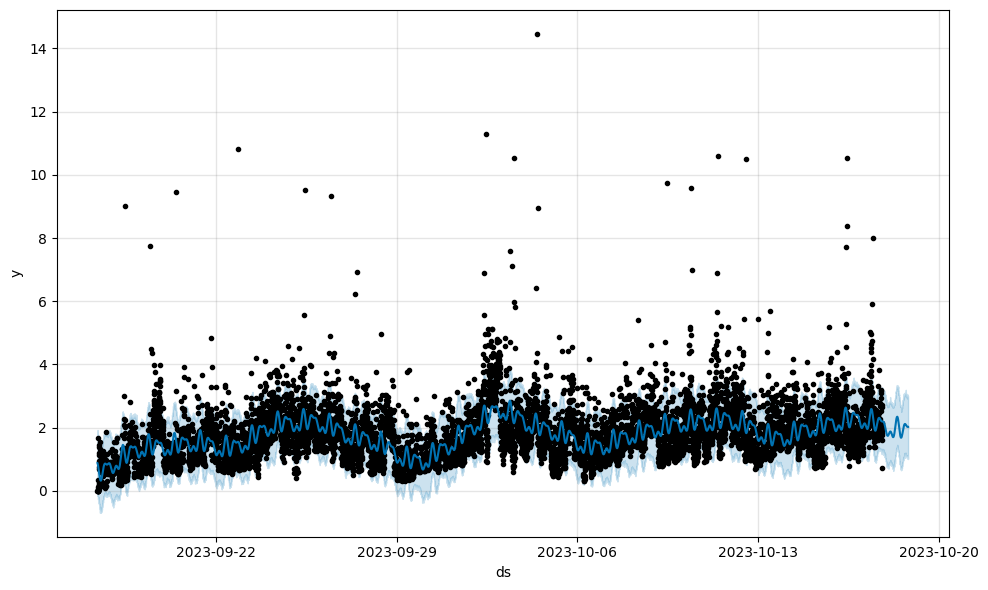

In [ ]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.show()

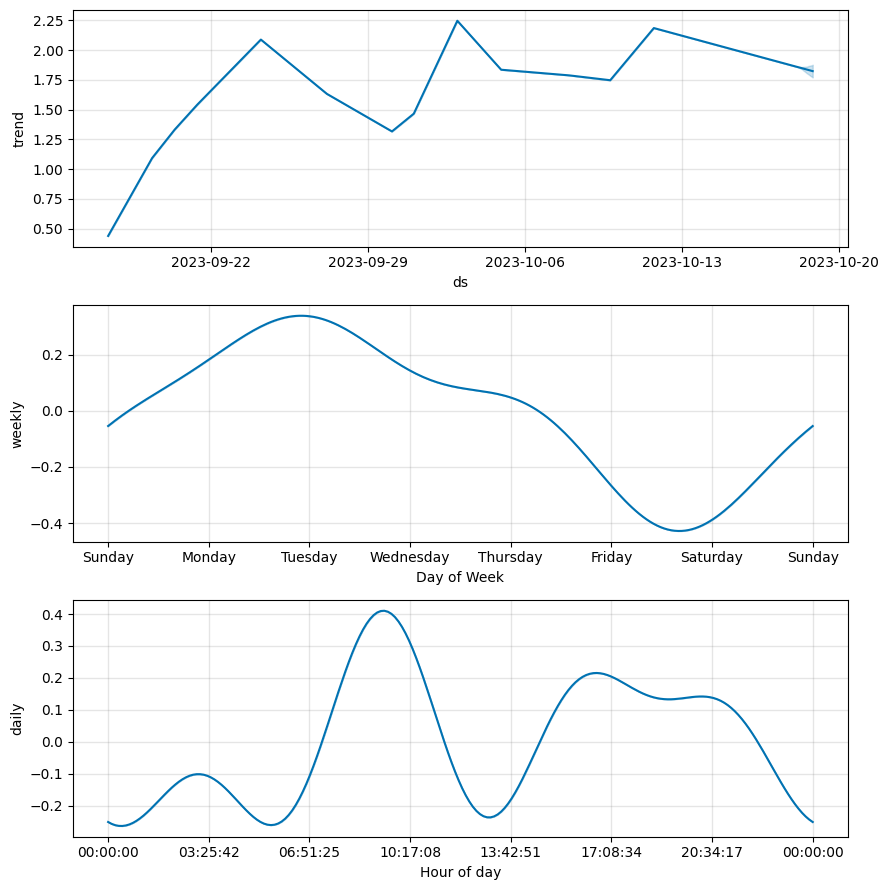

In [ ]:
# Plot components
fig2 = model.plot_components(forecast)
plt.show()